# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.2.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-65.3.0-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 119.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 162.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 208.2 MB/s eta 0:00:00
     ━━━━━━━

### Setup Kaggle API Key

In [22]:
!pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "ramygendy"
kaggle_key = "30707dd8bd8cea0ecdd98d0c767c2863"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [5]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

/bin/sh: 1: kaggle: not found
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [21]:
!pip install ipywidgets

In [22]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [6]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
# for feature information summary
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [11]:
predictor = TabularPredictor(
    label="count", 
    eval_metric = 'root_mean_squared_error',
    verbosity=0,
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)

2022-09-06 13:13:05,986	WARNING services.py:2013 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=1.00gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


### Review AutoGluon's training run with ranking of models that did the best.

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.821508      10.725163  510.241431                0.000824           0.339873            3       True         15
1   RandomForestMSE_BAG_L2  -53.359858       9.809289  412.301142                0.605512          25.450099            2       True         12
2     ExtraTreesMSE_BAG_L2  -53.942636       9.809908  395.040061                0.606131           8.189018            2       True         14
3          LightGBM_BAG_L2  -55.151952       9.419839  409.256361                0.216061          22.405318            2       True         11
4          CatBoost_BAG_L2  -55.636306       9.296635  453.857123                0.092858          67.006080            2       True         13
5        LightGBMXT_BAG_L2  -60.349094      12.311754  435.147136         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -

### Create predictions from test dataset

In [15]:
predictions = predictor.predict(test)
predictions.head()

0    23.615231
1    41.239639
2    44.968620
3    48.953674
4    51.668434
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [16]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.437645
std        90.176407
min         2.862666
25%        20.353977
50%        62.494202
75%       169.084122
max       364.172607
Name: count, dtype: float64

In [17]:
# How many negative values do we have?
predictions.lt(0).sum().sum()

0

In [18]:
# Set them to zero
predictions = predictions.clip(lower=0)

### Set predictions to submission dataframe, save, and submit

In [19]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [23]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 378kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [24]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2022-09-06 12:33:24  first raw submission  complete  1.81326      1.81326       
submission.csv  2022-09-06 07:40:13  first raw submission  complete  1.80293      1.80293       


#### Initial score of `1.81326`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

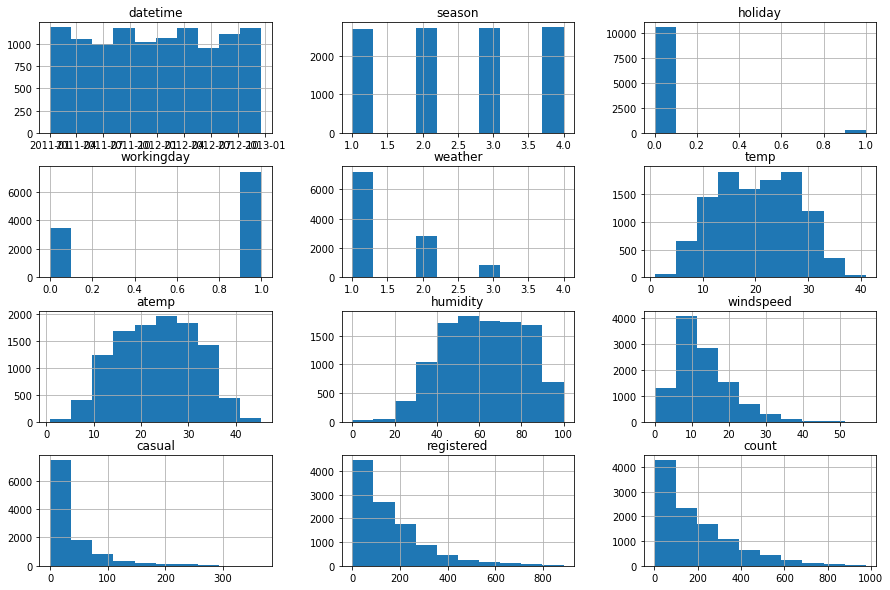

In [25]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize = (15,10));

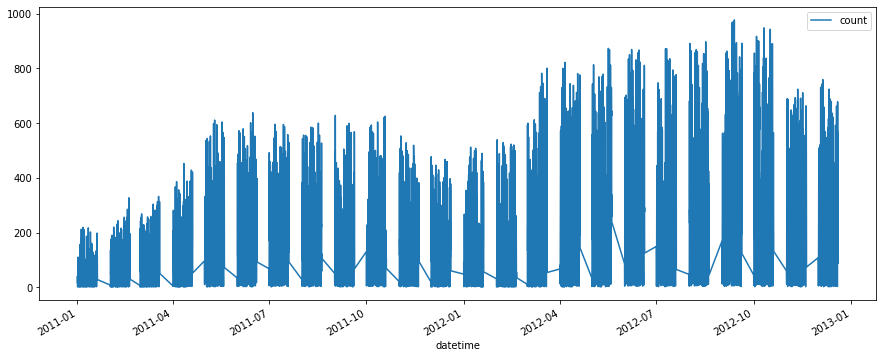

In [26]:
# time series plot for demand
train.plot(x='datetime', y='count', figsize=(15, 6));

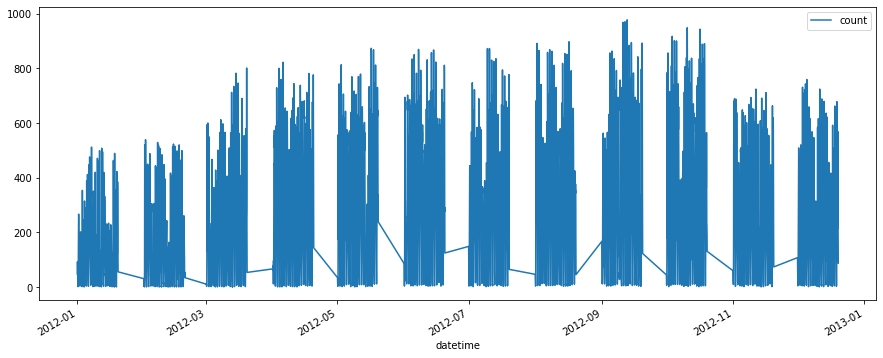

In [27]:
# time series plot for demand for a particular year
train.loc[train.datetime.dt.year == 2012].plot(x='datetime', y='count', figsize=(15, 6));

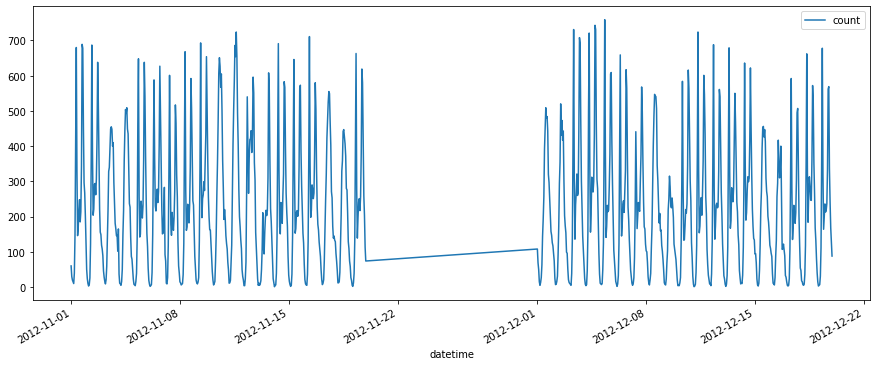

In [28]:
# time series plot for two consecutive months
train.loc[(train.datetime.dt.year == 2012) & ((train.datetime.dt.month == 11) | (train.datetime.dt.month == 12))].plot(x='datetime', y='count', figsize=(15, 6));

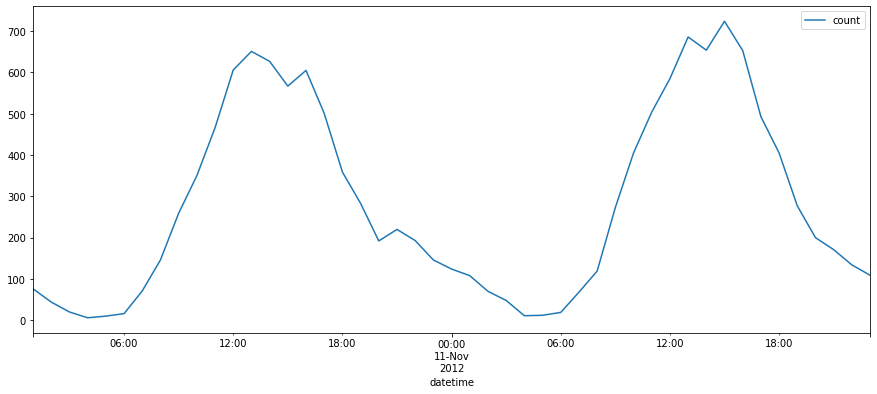

In [29]:
# time series plot for a particular weekend
train.loc[(train.datetime > '2012-11-10') & (train.datetime < '2012-11-12')].plot(x='datetime', y='count', figsize=(15, 6));

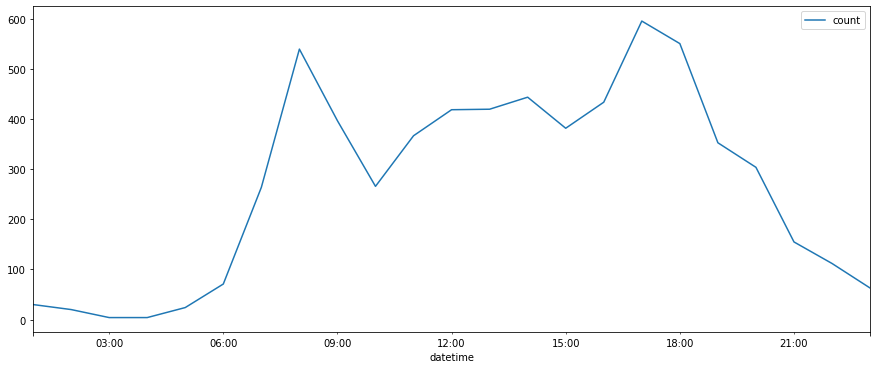

In [30]:
# time series plot for a particular weekday: Monday
train.loc[(train.datetime > '2012-11-12') & (train.datetime < '2012-11-13')].plot(x='datetime', y='count', figsize=(15, 6));

In [31]:
# Seperate hour, day, month from datetime
train['hour'] = train['datetime'].dt.hour
train['day'] = train['datetime'].dt.day
train['month'] = train['datetime'].dt.month
test['hour'] = test['datetime'].dt.hour
test['day'] = test['datetime'].dt.day
test['month'] = test['datetime'].dt.month

In [32]:
# create a new feature: time_of_day
def get_time_of_day(x):
    if (x > 4) and (x <= 8):
        return 0 # Early Morning
    elif (x > 8) and (x <= 12 ):
        return 1 # Morning
    elif (x > 12) and (x <= 16):
        return 2 # Noon
    elif (x > 16) and (x <= 20) :
        return 3 # Evening
    elif (x > 20) and (x <= 24):
        return 4 # Night
    elif (x <= 4):
        return 5 # Late Night

In [33]:
# apply new feature
train['time_of_day'] = train['hour'].apply(get_time_of_day)
test['time_of_day'] = test['hour'].apply(get_time_of_day)

In [34]:
# create a new feature: temp_category
def get_temp_category(x):
    if x <= 10:
        return 0 # low temp
    elif (x > 10) and (x <= 25 ):
        return 1 # mild temp
    elif (x > 25):
        return 2 # hot temp

In [35]:
train['temp_category'] = train['temp'].apply(get_temp_category)
test['temp_category'] = test['temp'].apply(get_temp_category)

In [36]:
# create a new feature: wind_category
def get_wind_category(x):
    if x <= 15:
        return 0 # normal wind
    elif (x > 10):
        return 1 # high wind

In [37]:
train['wind_category'] = train['windspeed'].apply(get_wind_category)
test['wind_category'] = test['windspeed'].apply(get_wind_category)

In [38]:
# create a new feature: humid_category
def get_humid_category(x):
    if x <= 30:
        return 0 # low humidity
    elif (x > 30) and (x <= 50 ):
        return 1 # normal humidity
    elif (x > 50):
        return 2 # high humidity

In [39]:
train['humid_category'] = train['humidity'].apply(get_humid_category)
test['humid_category'] = test['humidity'].apply(get_humid_category)

In [40]:
# create a new feature: atemp_category
def get_atemp_category(x):
    if x <= 10:
        return 0 # low temp
    elif (x > 10) and (x <= 25 ):
        return 1 # mild temp
    elif (x > 25):
        return 2 # hot temp

In [41]:
train['atemp_category'] = train['atemp'].apply(get_atemp_category)
test['atemp_category'] = test['atemp'].apply(get_atemp_category)

In [42]:
train.drop(['datetime', 'temp', 'windspeed', 'humidity', 'atemp'], axis=1, inplace=True)
test.drop(['datetime', 'temp', 'windspeed', 'humidity', 'atemp'], axis=1, inplace=True)

In [43]:
import seaborn as sn
import matplotlib.pyplot as plt

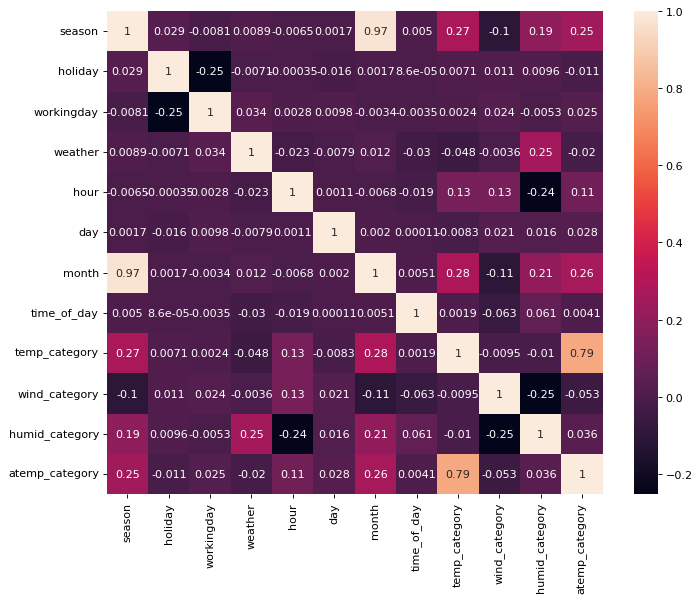

In [44]:
plt.figure(figsize=(10, 8), dpi=80)
sn.heatmap(train.drop(['count', 'registered','casual'], axis=1).corr(), annot=True)
plt.show()

In [45]:
# removing season column as it's having very high correlation with month
train.drop(['season'], axis=1, inplace=True)
test.drop(['season'], axis=1, inplace=True)

In [46]:
train['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [47]:
train["weather"] = train["weather"].astype('category')
train["time_of_day"] = train["time_of_day"].astype('category')
train["temp_category"] = train["temp_category"].astype('category')
train["wind_category"] = train["wind_category"].astype('category')
train["humid_category"] = train["humid_category"].astype('category')
train["holiday"] = train["holiday"].astype('category')
train["workingday"] = train["workingday"].astype('category')
train["hour"] = train["hour"].astype('category')
train["month"] = train["month"].astype('category')

In [48]:
test["weather"] = test["weather"].astype('category')
test["time_of_day"] = test["time_of_day"].astype('category')
test["temp_category"] = test["temp_category"].astype('category')
test["wind_category"] = test["wind_category"].astype('category')
test["humid_category"] = test["humid_category"].astype('category')
test["holiday"] = test["holiday"].astype('category')
test["workingday"] = test["workingday"].astype('category')
test["hour"] = test["hour"].astype('category')
test["month"] = test["month"].astype('category')

In [49]:
# View are new feature
train.head()

,holiday,workingday,weather,casual,registered,count,hour,day,month,time_of_day,temp_category,wind_category,humid_category,atemp_category
0,0,0,1,3,13,16,0,1,1,5,0,0,2,1
1,0,0,1,8,32,40,1,1,1,5,0,0,2,1
2,0,0,1,5,27,32,2,1,1,5,0,0,2,1
3,0,0,1,3,10,13,3,1,1,5,0,0,2,1
4,0,0,1,0,1,1,4,1,1,5,0,0,2,1


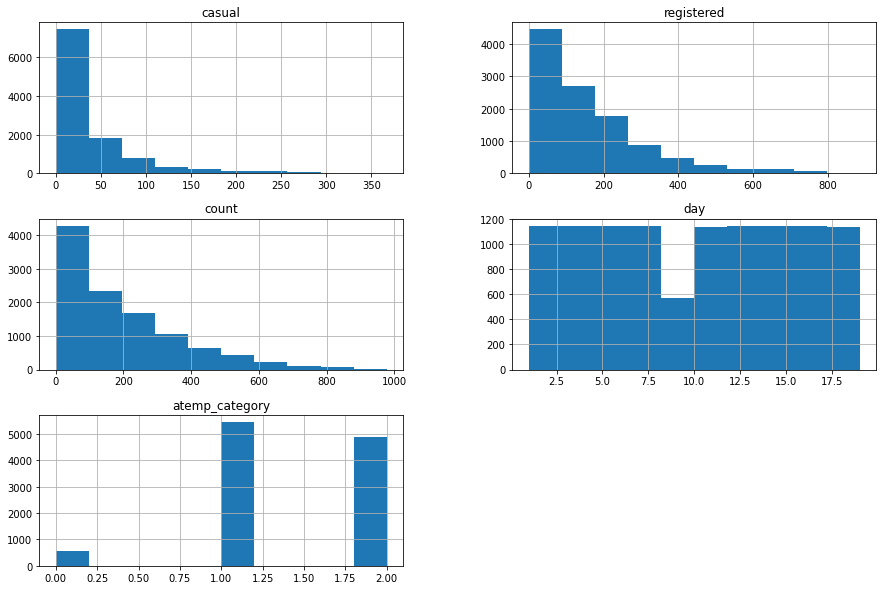

In [50]:
# View histogram of all features again now with the hour feature
train.hist(figsize = (15,10));

## Step 5: Rerun the model with the same settings as before, just with more features

In [51]:
predictor_new_features = TabularPredictor(
    label="count", 
    verbosity=0,
    eval_metric = 'root_mean_squared_error', 
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality"
)


2022-09-06 12:35:14,086	WARNING services.py:2013 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.77gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


In [52]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -60.643098      10.733175  516.493874                0.000787           0.338976            3       True         15
1     ExtraTreesMSE_BAG_L2  -60.799983      10.360237  401.976051                0.605796           7.503557            2       True         14
2          CatBoost_BAG_L2  -61.624191       9.937707  487.926456                0.183267          93.453962            2       True         13
3          LightGBM_BAG_L2  -61.796617       9.943326  415.197379                0.188885          20.724885            2       True         11
4   RandomForestMSE_BAG_L2  -61.969761      10.378713  415.904506                0.624272          21.432011            2       True         12
5      WeightedEnsemble_L2  -62.569586       8.519287  336.693992         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -201.39398754905193,
  'KNeighborsDist_BAG_L1': -201.39385023214737,
  'LightGBMXT_BAG_L1': -65.98549025838962,
  'LightGBM_BAG_L1': -

In [66]:
# Get predictions
predictions = predictor_new_features.predict(test)

In [67]:
predictions.describe()

count    6493.000000
mean      195.957016
std       168.005753
min         2.957484
25%        53.168732
50%       163.201874
75%       285.727783
max       851.007202
Name: count, dtype: float64

In [68]:
# Remember to set all negative values to zero
predictions = predictions.clip(lower=0)

In [69]:
# Same submitting predictions
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=['datetime'])
submission_new_features["count"] = predictions
# Round count column values
submission_new_features['count'] = submission_new_features['count'].apply(lambda x: round(x))
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [70]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 249kB/s]
Successfully submitted to Bike Sharing Demand

In [71]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2022-09-06 13:04:28  new features          complete  0.55831      0.55831       
submission.csv               2022-09-06 12:33:24  first raw submission  complete  1.81326      1.81326       
submission.csv               2022-09-06 07:40:13  first raw submission  complete  1.80293      1.80293       


#### New Score of `0.55831`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
!pip install -q ipywidgets==7.4.2

In [36]:
import numpy as np
import autogluon.core as ag

In [47]:
nn_options = {
    'num_epochs': 10,
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),
    'layers': ag.space.Categorical([100],[1000],[200,100],[300,200,100]),
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),
}

gbm_options = {
    'num_boost_round': 100,
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36)
}

hyperparameters = {
    'GBM': gbm_options,
    'CAT': {'iterations': 10000},
    'NN': nn_options
} 

hyperparameter_tune_kwargs = { 
    'scheduler': 'local',
    'searcher': 'auto' 
}

In [48]:
predictor_new_hpo = TabularPredictor(
    label="count", 
    verbosity=0,
    eval_metric='root_mean_squared_error', 
    learner_kwargs={"ignored_columns": ["casual", "registered"]}
).fit(
    train_data=train,
    time_limit=600, 
    presets="best_quality",
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)

In [27]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   -1.896800      41.493891  280.871128                0.000920           0.339427            3       True         14
1     ExtraTreesMSE_BAG_L2   -1.902177      26.930687  183.819579                0.462036           5.597034            2       True         13
2   RandomForestMSE_BAG_L2   -2.048027      26.883882  195.831696                0.415231          17.609150            2       True         11
3      WeightedEnsemble_L2   -2.076600      26.263011  178.564399                0.000753           0.413088            2       True          8
4      WeightedEnsemble_L4   -2.094584      56.461766  469.218702                0.000810           0.274270            4       True         19
5   RandomForestMSE_BAG_L3   -2.125610      41.989006  354.150122         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L3': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L3': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L4': 'WeightedEnsemble

In [29]:
predictions = predictor_new_hpo.predict(test)

KeyError: "2 required columns are missing from the provided dataset to transform using AutoMLPipelineFeatureGenerator. Missing columns: ['casual', 'registered']"

In [30]:
# Remember to set all negative values to zero
predictions = predictions.clip(lower=0)

NameError: name 'predictions' is not defined

In [ ]:
# Same submitting predictions
submission_new_hpo["count"] = ?
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

In [ ]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

In [ ]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

In [ ]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [?, ?, ?]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [ ]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [?, ?, ?],
    "hpo2": [?, ?, ?],
    "hpo3": [?, ?, ?],
    "score": [?, ?, ?]
})